In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(1)

data_file = 'data/retail_rfm.csv'

# Read in RFM data
rfm = pd.read_csv(data_file)

In [2]:
# Define the number of groups
groups = 5

# Function to calculate ntile
def ntile(x, n):
    return np.ceil(x.rank()/len(x) * n)

# Run RFM Analysis with Independent Sort
rfm['recency_score_indep'] = ntile(-rfm['recency_days'], groups)
rfm['frequency_score_indep'] = ntile(rfm['number_of_orders'], groups)
rfm['monetary_score_indep'] = ntile(rfm['revenue'], groups)
rfm['rfm_score_indep'] = (rfm['recency_score_indep']*100 + rfm['frequency_score_indep'] * 10 + rfm['monetary_score_indep']).astype(str)



In [4]:
# Run RFM Analysis with Sequential Sort
rfm['recency_score_seq'] = ntile(-rfm['recency_days'], groups)

# Initialize empty lists
r_groups = []
rf_groups = []
temp = pd.DataFrame()

for r in range(1, groups+1):
    r_group = rfm[rfm['recency_score_seq'] == r]
    r_group['frequency_score_seq'] = ntile(r_group['number_of_orders'], groups)
    for m in range(1, groups+1):
        rf_group = r_group[r_group['frequency_score_seq'] == m]
        rf_group['monetary_score_seq'] = ntile(rf_group['revenue'], groups)
        temp = pd.concat([temp, rf_group], axis=0)

rfm_result = temp.sort_values('customer_id')
rfm_result['rfm_score_seq'] = (rfm_result['recency_score_seq']*100 + rfm_result['frequency_score_seq'] * 10 + rfm_result['monetary_score_seq']).astype(str)

# Export RFM Results with Independent and Sequential Sort
rfm_result.to_csv('data/rfm_result.csv', index=False)


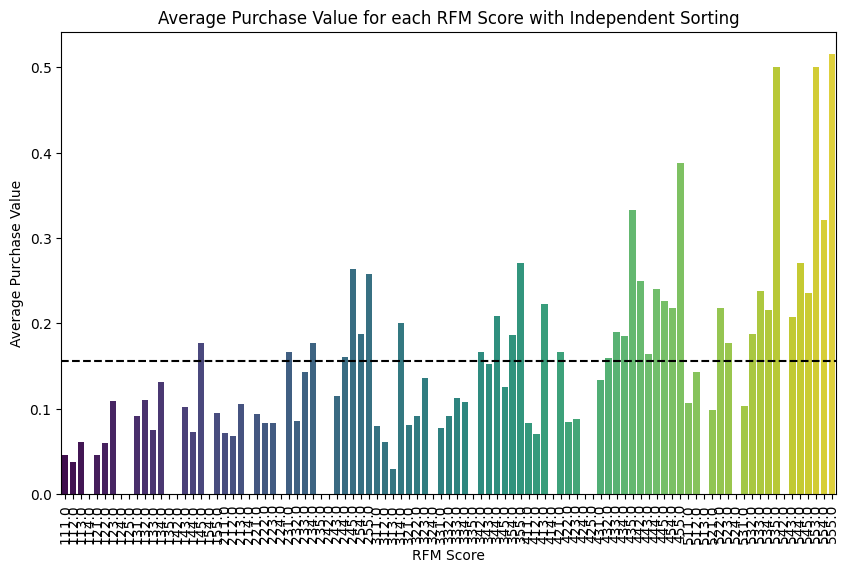

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a new DataFrame with average purchase value for each RFM score
rfm_avg_purchase = rfm_result.groupby('rfm_score_indep')['purchase'].mean().reset_index()

# Create bar plot
plt.figure(figsize=(10, 6))
rfm_plot_indep = sns.barplot(data=rfm_avg_purchase, x='rfm_score_indep', y='purchase', palette='viridis')
rfm_plot_indep.axhline(y = 0.15625, color = 'black', linestyle = '--')
plt.title('Average Purchase Value for each RFM Score with Independent Sorting')
plt.xlabel('RFM Score')
plt.ylabel('Average Purchase Value')
plt.xticks(rotation=90)  # Rotates X-axis labels if they overlap
plt.show()


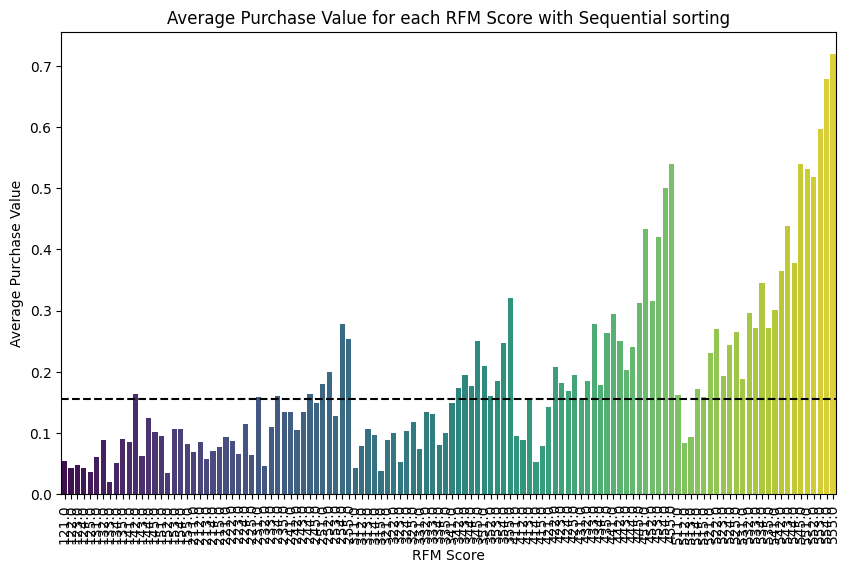

In [8]:
rfm_avg_purchase = rfm_result.groupby('rfm_score_seq')['purchase'].mean().reset_index()

# Create bar plot
plt.figure(figsize=(10, 6))
rfm_plot_seq = sns.barplot(data=rfm_avg_purchase, x='rfm_score_seq', y='purchase', palette='viridis')
rfm_plot_seq.axhline(y = 0.15625, color = 'black', linestyle = '--')
plt.title('Average Purchase Value for each RFM Score with Sequential sorting')
plt.xlabel('RFM Score')
plt.ylabel('Average Purchase Value')
plt.xticks(rotation=90)  # Rotates X-axis labels if they overlap
plt.show()

In [54]:
# Helper function for conditional formatting
def highlight_cells(val):
    color = '#90EE90' if val > 0.15625 else ''
    return 'background-color: {}'.format(color)

percentage_table = pd.pivot_table(rfm_result, 
                                    values='purchase', 
                                    index=['recency_score_indep', 'frequency_score_indep'], 
                                    columns='monetary_score_indep', 
                                    aggfunc='mean', 
                                    fill_value=0)

percentage_table_style = percentage_table.style.applymap(highlight_cells)

percentage_table_style

In [49]:
count_table = pd.pivot_table(rfm_result, 
                                    values='purchase', 
                                    index=['recency_score_indep', 'frequency_score_indep'], 
                                    columns='monetary_score_indep', 
                                    aggfunc='count', 
                                    fill_value='')

count_table

monetary_score_indep                         1.0    2.0    3.0    4.0    5.0
recency_score_indep frequency_score_indep                                   
1.0                 1.0                    588.0  186.0   49.0   11.0       
                    2.0                    130.0  269.0   83.0   15.0    2.0
                    3.0                     22.0  173.0  214.0   61.0    7.0
                    4.0                             4.0   59.0   83.0   17.0
                    5.0                                           5.0   21.0
2.0                 1.0                    294.0  117.0   19.0    3.0       
                    2.0                    139.0  180.0   60.0    8.0       
                    3.0                     18.0  187.0  286.0   79.0    6.0
                    4.0                             7.0  105.0  275.0   57.0
                    5.0                                          32.0  120.0
3.0                 1.0                    300.0   82.0   34.0    5.0       
                    2.0                     62.0  176.0   44.0   10.0       
                    3.0                     13.0  165.0  275.0  102.0    2.0
                    4.0                             6.0   92.0  316.0   80.0
                    5.0                                          43.0  207.0
4.0                 1.0                    145.0   43.0    9.0    2.0       
                    2.0                     42.0   95.0   34.0    4.0    2.0
                    3.0                     15.0  113.0  184.0   70.0    3.0
                    4.0                             4.0  110.0  379.0   93.0
                    5.0                                          78.0  564.0
5.0                 1.0                    113.0   35.0    1.0              
                    2.0                     81.0   55.0   17.0    4.0       
                    3.0                     29.0  112.0  172.0   37.0    6.0
                    4.0                             4.0  145.0  266.0   51.0
                    5.0                                    4.0  112.0  762.0

In [42]:
percentage_table_seq = pd.pivot_table(rfm_result, 
                                    values='purchase', 
                                    index=['recency_score_seq', 'frequency_score_seq'], 
                                    columns='monetary_score_seq', 
                                    aggfunc='mean', 
                                    fill_value=0)

percentage_table_seq = percentage_table_seq.style.applymap(highlight_cells)

count_table_seq = pd.pivot_table(rfm_result, 
                                    values='purchase', 
                                    index=['recency_score_seq', 'frequency_score_seq'], 
                                    columns='monetary_score_seq', 
                                    aggfunc='count', 
                                    fill_value=0)

In [43]:
percentage_table_seq

In [126]:
selection_seq_df = rfm_result.groupby(['rfm_score_seq'])['purchase'].mean().reset_index()
selection_seq_df['target_seq'] = np.where(selection_seq_df.purchase > 0.15625, 1, 0)

selection_ind_df = rfm_result.groupby(['rfm_score_indep'])['purchase'].mean().reset_index()
selection_ind_df['target_ind'] = np.where(selection_ind_df.purchase > 0.15625, 1, 0)
targetting_df = rfm_result.merge(selection_ind_df[['rfm_score_indep', 'target_ind']], on='rfm_score_indep').merge(selection_seq_df[['rfm_score_seq', 'target_seq']], on='rfm_score_seq')

In [128]:
targetting_df['target_all'] = 1

In [142]:
targetting_df['marketing_cost'] = 2.00
targetting_df['shipping_cost'] = np.where(targetting_df.purchase == 1, 6.00, 0.00)
targetting_df['revenue_campaign'] = np.where(targetting_df.purchase == 1, 40.00, 0.00)
targetting_df['cost_goods'] = np.where(targetting_df.purchase == 1, 19.20, 0.00)
targetting_df['profit'] = targetting_df.revenue_campaign - targetting_df.cost_goods - targetting_df.marketing_cost - targetting_df.shipping_cost


In [150]:
pd.set_option('display.float_format', '{:.2f}'.format)

agg_dict = {
    'customer_id': 'count', 
    'purchase': 'sum',
    'revenue_campaign': 'sum', 
    'cost_goods': 'sum', 
    'shipping_cost': 'sum', 
    'marketing_cost': 'sum', 
    'profit': 'sum'
}

# Group by target_ind and target_seq, and aggregate
summary_target_ind = targetting_df[targetting_df['target_ind'] == 1].agg(agg_dict)
summary_target_seq = targetting_df[targetting_df['target_seq'] == 1].agg(agg_dict)
summary_all = targetting_df.agg(agg_dict)

# Calculate ROMI
summary_target_ind['ROMI'] = summary_target_ind['profit'] / summary_target_ind['marketing_cost']
summary_target_seq['ROMI'] = summary_target_seq['profit'] / summary_target_seq['marketing_cost']
summary_all['ROMI'] = summary_all['profit'] / summary_all['marketing_cost']

# Calculate Response Rate
summary_target_ind['Response Rate'] = summary_target_ind['purchase'] / summary_target_ind['customer_id']
summary_target_seq['Response Rate'] = summary_target_seq['purchase'] / summary_target_seq['customer_id']
summary_all['Response Rate'] = summary_all['purchase'] / summary_all['customer_id']




In [ ]:
# Combine into a single DataFrame
summary = pd.DataFrame({
    'All customers': summary_all, 
    'Target_ind': summary_target_ind,
    'Target_seq': summary_target_seq
})

# Some formatting

# Create a copy of the DataFrame for formatting
summary_formatted = summary.copy()

# Define the formatting for each cell
for column in summary_formatted.columns:
    for row in summary_formatted.index:
        if row in ['customer_id', 'purchase']:
            summary_formatted.loc[row, column] = '{:,.0f}'.format(summary.loc[row, column])
        elif row in ['ROMI', 'Response Rate']:
            summary_formatted.loc[row, column] = '{:.2f}%'.format(summary.loc[row, column] * 100)
        else:
            summary_formatted.loc[row, column] = '${:,.2f}'.format(summary.loc[row, column])

In [151]:
summary_formatted

,All customers,Target_ind,Target_seq
customer_id,"10,000","4,563","4,657"
purchase,"1,779","1,324","1,335"
revenue_campaign,"$71,160.00","$52,960.00","$53,400.00"
cost_goods,"$34,156.80","$25,420.80","$25,632.00"
shipping_cost,"$10,674.00","$7,944.00","$8,010.00"
marketing_cost,"$20,000.00","$9,126.00","$9,314.00"
profit,"$6,329.20","$10,469.20","$10,444.00"
ROMI,31.65%,114.72%,112.13%
Response Rate,17.79%,29.02%,28.67%
